#### Project notes based on other presentations
- Have a conservation check for each run
- show diagram of grid
- insert CFL condition
- grid sensitivity study
- mention the grids and discretizations
- mention bugs or issues you ran into
- mathematical introduction before discretization

In [280]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('./assets/custom.mplstyle')

#### Grid indexing philosophy

`j` corresponds to the y-axis \
`i` corresponds to the x-axis

#### Grid basis setup

In [385]:
# Define grid point parameters
x_min, x_max = [0, 1]
z_min, z_max = [0, 1]
dx, dz = 0.1, 0.1
# Define base grid basis "vectors" (bv) to outline grid formation (step size added to maximum bound to include it)
bv_base_x = np.arange(x_min, x_max+dx, dx)
bv_base_z = np.arange(z_min, z_max+dz, dz)
# Build base grid meshgrid
base_x, base_z = np.meshgrid(bv_base_x, bv_base_z)

# Build staggered grid (1/2 points)
bv_stag_x = np.arange(x_min-dx/2, x_max+dx, dx)
bv_stag_z = np.arange(z_min-dz/2, z_max+dz, dz)
# Build staggered grid meshgrid
stag_x, stag_z = np.meshgrid(bv_stag_x, bv_stag_z)

# CFL number
cfl = 0.5
# Timestep (assume c = 1)
dt = cfl*dx
# Number of timesteps
n_steps = 5
# Time domain
times = np.arange(0, dt*n_steps, dt)

#### Constants

In [386]:
g = 9.81
p_0 = 101325
rho_0 = 1.225
u_0, w_0 = 0, 0

#### Initial disturbance

In [387]:
rho_init = np.full(shape=(len(base_z), len(base_x), len(times)), fill_value=rho_0)
center_x = len(base_x) // 2
rho_init[0, ((center_x-2)+1):(center_x+2)] = rho_0-0.1

#### Initialize grids

In [388]:
rho = {'name': '$\\rho$',
       'long_name': 'Density',
       'units': r'kg m$^{-3}$',
       'values': np.full(shape=(len(base_z), len(base_x), len(times)), fill_value=rho_init)}

u = {'name': '$u$',
          'long_name': 'Velocity, horizontal',
          'units': r'm s$^{-1}$',
          'values': np.full(shape=(len(stag_z), len(stag_x), len(times)), fill_value=u_0)}

w = {'name': '$w$',
          'long_name': 'Velocity, vertical',
          'units': r'm s$^{-1}$',
          'values': np.full(shape=(len(stag_z), len(stag_x), len(times)), fill_value=w_0)}

#### First-pass discretization
__Spatial__: 2nd-order centered difference, B-grid (u, w on the 1/2 points, $\rho$ on the integer points) \
__Temporal__: forward Euler

In [473]:
def disc(base, stag, refs, dx, dz, dt):
    
    # Load reference values
    rho_0, p_0 = refs
    # Load current values (n)
    x, z, rho, p = base
    x_s, z_s, u, w = stag
    
    # Initialize new values (n+1 represented by _n)
    rho_n = np.full(shape=(len(z), len(x)), fill_value=rho)
    p_n = np.full(shape=(len(z), len(x)), fill_value=p)
    u_n = np.full(shape=(len(z_s), len(x_s)), fill_value=u)
    w_n = np.full(shape=(len(z_s), len(x_s)), fill_value=w)
    
    for j in range(0, len(z)):
        for i in range(0, len(x)):
            
            i_s, j_s = i, j # placeholder staggered indices, in case changes need to be made to staggered grid fields
            
            # Create modulo-based indices
            l, r = (i-1) % len(x), (i+1) % len(x) # left (l) and right (r)
            a, b = (j+1) % len(z), (j-1) % len(z) # above (a) and below (b)
            l_s, r_s = (i_s-1) % len(x_s), (i_s+1) % len(x_s) # left (l) and right (r) - staggered
            a_s, b_s = (j_s+1) % len(z_s), (j_s-1) % len(z_s) # above (a) and below (b) - staggered
            
            print('({0:2}, {1:2}) | ({2}) and ({3}) | u: {4:3.2f}, w: {5:3.2f}, rho: {6:3.2f}'.format(i, j, (l, r, a, b), (l_s, r_s, a_s, b_s), u[j_s, i_s], w[j_s, i_s], rho[j, i]))
            
            # Step horizontal velocity in time - revisit indexing for velocity updates
            du_dx = (u[j_s, i_s+1] - u[j_s, i_s-1])/(2*dx)
            du_dz = (u[j_s+1, i_s] - u[j_s-1, i_s])/(2*dz)
            dphi_dx = ((p[j, i+1]-p_0) - (p[j, i-1]-p_0))/(2*dx)
            u_n[j_s, i_s] = u[j_s, i_s] + dt*(-u[j_s, i_s]*du_dx - w[j_s, i_s]*du_dz + dphi_dx/rho_0)
            
            # Step vertical velocity in time - revisit indexing for velocity updates
            dw_dx = (w[j_s, i_s+1] - w[j_s, i_s-1])/(2*dx)
            dw_dz = (w[j_s+1, i_s] - w[j_s-1, i_s])/(2*dz) 
            dphi_dz = ((p[j+1, i]-p_0) - (p[j-1, i]-p_0))/(2*dz*rho_0)
            w_n[j_s, i_s] = w[j_s, i_s] + dt*(-u[j_s, i_s]*dw_dx - w[j_s, i_s]*dw_dz - dphi_dz/rho_0 - g*(rho[j, i] - rho_0)/rho_0)
            
            # Step density in time
            u_ = np.mean(u[j_s, i_s] + u[j_s+1, i_s] + u[j_s, i_s+1] + u[j_s+1, i_s+1]) # get average velocity for the integer point
            w_ = np.mean(w[j_s, i_s] + w[j_s+1, i_s] + w[j_s, i_s+1] + w[j_s+1, i_s+1]) # get average velocity for the integer point
            drho_dx = ((rho[i+1, j]-rho_0) - (rho[i-1, j]-rho_0))/(2*dx)
            drho_dz = ((rho[i, j+1]-rho_0) - (rho[i, j-1]-rho_0))/(2*dz)
            rho_n = (rho[i, j] - rho_0) - dt*(u_*drho_dx + w_*drho_dz)
            
            # Step pressure forward in time
            p_n[j, i] = p[j, i] - rho[j, i]*g*z[j, i]
            
    return rho_n, p_n, u_n, w_n

#### Main

In [474]:
p = {'name': '$p$',
       'long_name': 'Pressure',
       'units': r'Pa',
       'values': np.full(shape=(len(base_z), len(base_x), len(times)), fill_value=p_0)}

p['values'][:, :, 0] = p_0 - rho['values'][:, :, 0]*g*base_z
                         
for step in range(1, len(times)):
    refs = [rho_0, p_0]
    base = [base_x, base_z, rho['values'][:, :, step-1], p['values'][:, :, step-1]]
    stag = [stag_x, stag_z, u['values'][:, :, step-1], w['values'][:, :, step-1]]
    rho['values'][:, :, step], p['values'][:, :, step], u['values'][:, :, step], w['values'][:, :, step] = disc(base, stag, refs, dx, dz, dt)

( 0,  0) | ((10, 1, 1, 10)) and ((11, 1, 1, 11)) | u: 0.00, w: 0.00, rho: 1.23
( 1,  0) | ((0, 2, 1, 10)) and ((0, 2, 1, 11)) | u: 0.00, w: 0.00, rho: 1.23
( 2,  0) | ((1, 3, 1, 10)) and ((1, 3, 1, 11)) | u: 0.00, w: 0.00, rho: 1.23
( 3,  0) | ((2, 4, 1, 10)) and ((2, 4, 1, 11)) | u: 0.00, w: 0.00, rho: 1.23
( 4,  0) | ((3, 5, 1, 10)) and ((3, 5, 1, 11)) | u: 0.00, w: 0.00, rho: 1.12
( 5,  0) | ((4, 6, 1, 10)) and ((4, 6, 1, 11)) | u: 0.00, w: 0.00, rho: 1.12
( 6,  0) | ((5, 7, 1, 10)) and ((5, 7, 1, 11)) | u: 0.00, w: 0.00, rho: 1.12
( 7,  0) | ((6, 8, 1, 10)) and ((6, 8, 1, 11)) | u: 0.00, w: 0.00, rho: 1.23
( 8,  0) | ((7, 9, 1, 10)) and ((7, 9, 1, 11)) | u: 0.00, w: 0.00, rho: 1.23
( 9,  0) | ((8, 10, 1, 10)) and ((8, 10, 1, 11)) | u: 0.00, w: 0.00, rho: 1.23
(10,  0) | ((9, 0, 1, 10)) and ((9, 11, 1, 11)) | u: 0.00, w: 0.00, rho: 1.23


IndexError: index 11 is out of bounds for axis 1 with size 11

#### Grid plotting

Text(0, 0.5, 'z')

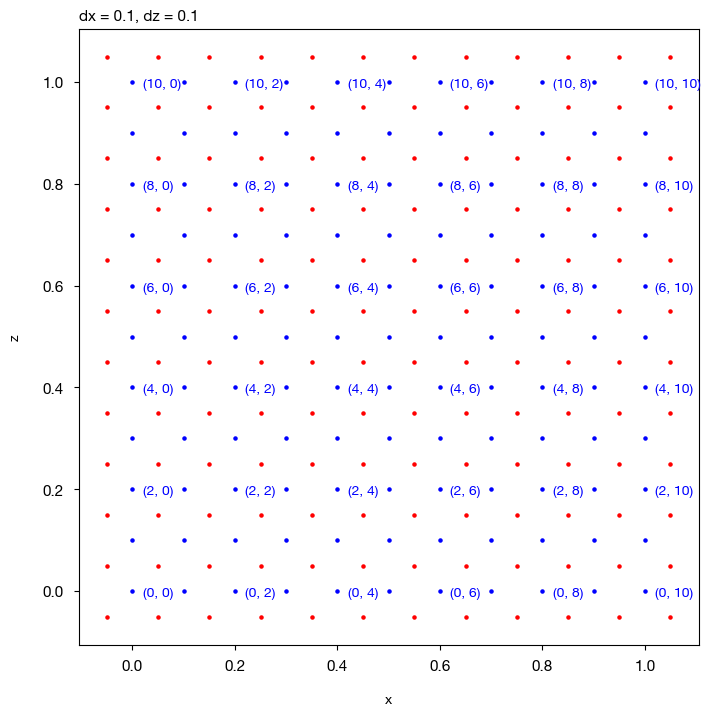

In [467]:
fig, ax = plt.subplots(figsize=(8, 8))
im_base = ax.scatter(base_x, base_z, s=5)
im_stag = ax.scatter(stag_x, stag_z, s=5)

point_labels = True

# Annotate grid points for troubleshooting
if point_labels == True:
    # Choose type of annotation for point labels [index = (i, j) space, absolute = (x, y) space]
    point_label_type = 'index' # choose 'index' or 'absolute'
    point_label_skip = 2 # print grid point label every N points
    for j, z in enumerate(base_z):
        for i, x in enumerate(base_x):
            point_label = '({0}, {1})'.format(j, i) if point_label_type == 'index' else '({0:.1f}, {1:.1f})'.format(x[i], z[j])
            if j % point_label_skip == 0 and i % point_label_skip == 0:
                ax.annotate(point_label, (x[i], z[j]), xytext=(x[i] + 0.02, z[j] - 0.01), fontsize=10, c='b')

# Axis properties
# ax.set_xlim([base_x.min(), base_x.max()])
# ax.set_ylim([base_z.min(), base_z.max()])
# Axis title
ax_title_str = 'dx = {0}, dz = {1}'.format(dx, dz)
ax.set_title(label=ax_title_str)
ax.set_xlabel('x')
ax.set_ylabel('z')

#### Field plots

In [425]:
from mpl_toolkits.axes_grid1 import make_axes_locatable as ml

def field_plot(grids, datasets, timestep=0):

    base_x, base_z = grids[0]
    stag_x, stag_z = grids[1]
    
    nrows, ncols = 1, len(datasets)
    fig, axs = plt.subplots(figsize=(3*ncols, 3*nrows), ncols=ncols, sharey=True)

    for i, data in enumerate(datasets):
        ax = axs[i]
        
        x, z = [base_x, base_z] if data['long_name'] in ['Density', 'Pressure'] else [stag_x, stag_z]

        im = ax.pcolormesh(x, z, data['values'][:, :, timestep])

        # Axis properties
        ax.set_xlim([x.min(), x.max()])
        ax.set_ylim([z.min(), z.max()])
        # Axis title
        ax.set_xlabel('x')
        ax.set_ylabel('z') if i == 0 else None

        # Colorbar
        cax_width = 0.25*ax.get_position().width
        divider = ml(ax)
        cax = divider.append_axes('right', size=cax_width, pad=0.1)
        # cax = fig.add_axes([ax.get_position().x1 + 0.03, 
        #                     ax.get_position().y0, 
        #                     cax_width, 
        #                     ax.get_position().height])
        cb = fig.colorbar(im, cax=cax)

        # Metadata
        ax_title_str = r'{0} ({1}), {2}'.format(data['long_name'], data['name'], data['units'])
        ax.set_title(label=ax_title_str)
        
    fig.tight_layout()

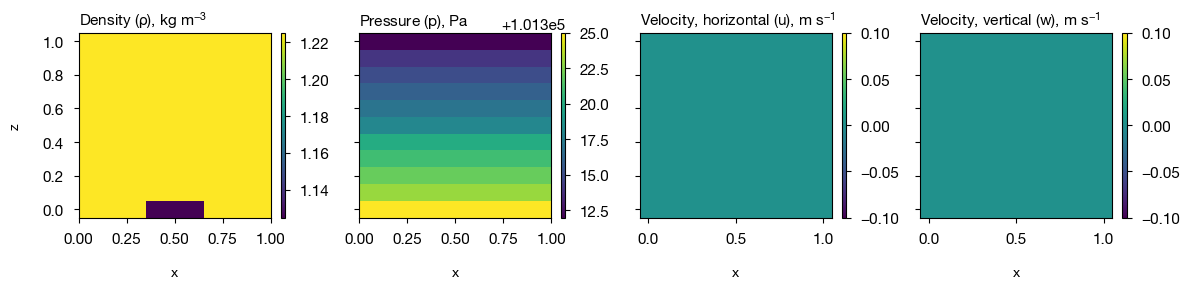

In [442]:
field_plot([(base_x, base_z), (stag_x, stag_z)], [rho, p, u, w], 0)

In [415]:
w['values'][:, :, 1]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])